In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/eye_state"

EEG98.71-1.ipynb  EEG-Eye-State.arff  EEGEyeState.arff	model


In [ ]:
import os.path
import urllib.request
import shutil

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff'
file_name = '/content/drive/My Drive/eye_state/EEGEyeState.arff'

# Si el archivo no existe o tiene tamaño 0, lo bajo
if not os.path.exists(file_name) or os.stat(file_name).st_size <= 0:
    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

In [ ]:
#file_name = 'EEGEyeState.arff'

In [ ]:
from scipy.io import arff
import pandas as pd
data, meta = arff.loadarff(file_name)
data = pd.DataFrame(data)
# Convierto la columna final a entero
data["eyeDetection"] = data["eyeDetection"].astype('int')
data.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


Outlier Removing

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


rng = np.random.RandomState(42)
factorContaminacion = 0.5/100 

cOneClassSVM = svm.OneClassSVM(nu=1 - factorContaminacion, kernel="rbf", gamma=0.1, random_state=rng)
cIsolationForest = IsolationForest(contamination=factorContaminacion, random_state=rng, n_jobs=-1)
cLocalOutlierFactor = LocalOutlierFactor(n_neighbors=35, contamination=factorContaminacion, n_jobs=-1)

cOneClassSVM.fit(X=data)
cIsolationForest.fit(X=data)
esOutlier = np.column_stack((cOneClassSVM.predict(X=data), cIsolationForest.predict(X=data), cLocalOutlierFactor.fit_predict(X=data))) == -1
esOutlier = esOutlier.sum(axis=1) >= 2

/usr/local/lib/python3.6/dist-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [ ]:
esOutlier.sum()

19

In [ ]:
validData = data[~esOutlier]
validData.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000,14961.000000
mean,4301.284253,4009.425433,4263.989699,4122.285475,4341.471710,4619.957046,4072.741916,4615.703193,4201.255304,4231.107323,4202.053115,4278.997516,4605.915226,4361.214690,0.449302
std,37.657989,29.974471,21.091153,20.701946,16.724244,18.166280,20.737372,18.110231,17.599426,19.500633,24.246670,19.854582,33.271561,38.374001,0.497440
min,4197.950000,3905.640000,4197.440000,4058.460000,4304.620000,4566.150000,4026.150000,4567.180000,4147.690000,4152.820000,4100.000000,4201.030000,4443.080000,4205.640000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,4504.100000,4156.920000,4386.150000,4250.260000,4463.590000,4756.920000,4178.460000,4731.790000,4320.000000,4362.560000,4332.310000,4394.870000,4833.850000,4573.330000,1.000000


# **Data Plotting**

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f605e4284e0>


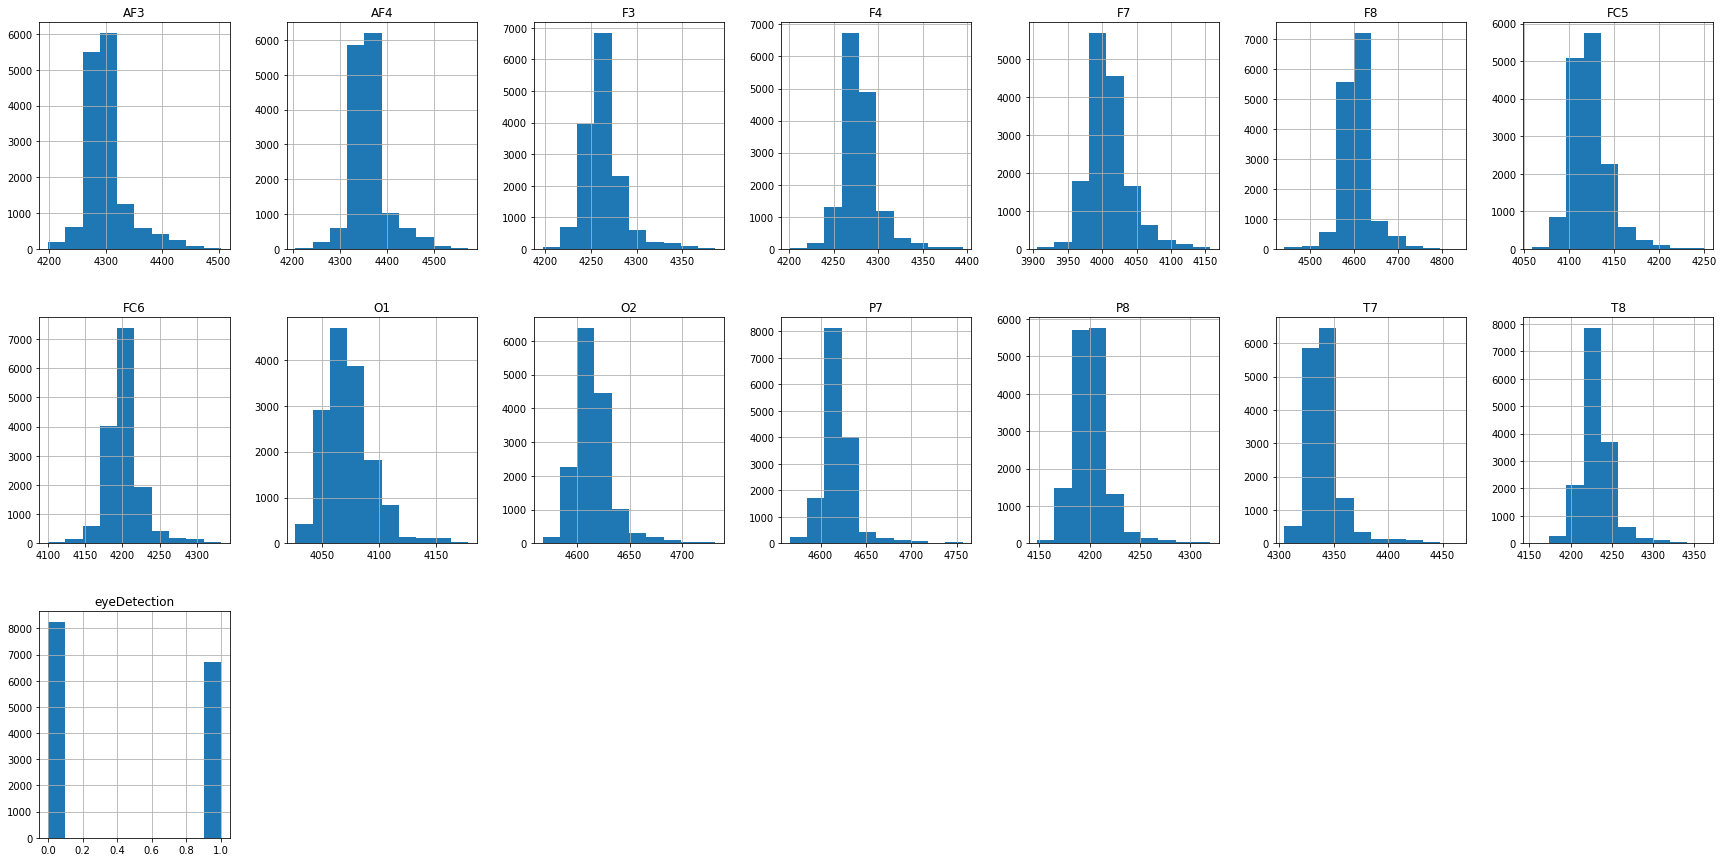

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

print(validData.hist(layout=(3, 7), figsize=(30, 15)))

In [ ]:
from sklearn.model_selection import train_test_split
labels = np.array(validData['eyeDetection'])
features= validData.drop('eyeDetection', axis = 1)
feature_list = list(features.columns)
#labels = validData['eyeDetection']
#features = np.array(features)
#print(features.shape)


# **Feature Selection**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(features,labels)

In [ ]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

In [ ]:
featureScores

,Specs,Score
0,AF3,49.079321
1,F7,47.567944
2,F3,6.958714
3,FC5,3.354903
4,T7,0.022559
5,P7,4.265138
6,O1,3.789316
7,O2,3.471120
8,P8,5.338305
9,T8,14.570144


In [ ]:
print(featureScores.nlargest(10,'Score'))

   Specs      Score
13   AF4  95.302822
12    F8  63.389187
0    AF3  49.079321
1     F7  47.567944
11    F4  21.487080
10   FC6  21.279531
9     T8  14.570144
2     F3   6.958714
8     P8   5.338305
5     P7   4.265138


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(features,labels)
print(model.feature_importances_)

[0.08059012 0.08695665 0.05864394 0.0636197  0.05762264 0.1044559
 0.11923198 0.05579971 0.04739394 0.05615271 0.05910239 0.06352636
 0.07300509 0.07389888]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


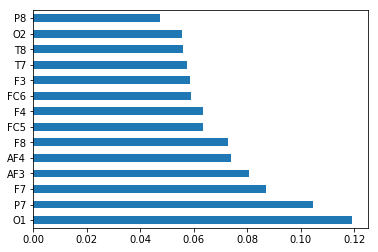

In [ ]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=features.columns)
feat_importances.nlargest(14).plot(kind='barh')
plt.show()

In [ ]:
!pip install deap

In [ ]:
features

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46
5,4321.03,4004.62,4284.10,4153.33,4345.64,4587.18,4093.33,4616.92,4202.56,4232.82,4209.74,4281.03,4628.21,4389.74
6,4319.49,4001.03,4280.51,4151.79,4343.59,4584.62,4089.74,4615.90,4212.31,4226.67,4201.03,4269.74,4625.13,4378.46
7,4325.64,4006.67,4278.46,4143.08,4344.10,4583.08,4087.18,4614.87,4205.64,4230.26,4195.90,4266.67,4622.05,4380.51
8,4326.15,4010.77,4276.41,4139.49,4345.13,4584.10,4091.28,4608.21,4187.69,4229.74,4202.05,4273.85,4627.18,4389.74
9,4326.15,4011.28,4276.92,4142.05,4344.10,4582.56,4092.82,4608.72,4194.36,4228.72,4212.82,4277.95,4637.44,4393.33


In [ ]:
features=features.drop(['P8','T8','F8','O2','FC6','F4'], axis = 1)

In [ ]:
features.shape

(14961, 6)

In [ ]:
features = np.array(features)

In [ ]:


from sklearn import preprocessing


# Escalo los conjuntos de datos usando la media y escala del conjunto de entrenamiento
scaler = preprocessing.StandardScaler().fit(features)
features = scaler.transform(features)
#sc_test_features = scaler.transform(test_features)
#sc_valid_features = scaler.transform(valid_features)


In [ ]:
features=features.reshape(14961,8,1)
#valid_features=sc_valid_features.reshape(3740,14,1)
#test_features=sc_test_features.reshape(3741,14,1)
#print(features.shape)
#print(valid_features.shape)
#valid_labels.shape
#test_features.shape


## Model **Training** 

In [ ]:
from keras.layers import * #Dense, Dropout, Conv1D,MaxPooling1D,AveragePooling1D, Flatten
from keras.models import Sequential,Model,Input
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import *#RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint,EarlyStopping
weight_decay = 1e-6
input_shape=[6,1]

model_input=Input(input_shape)
def first_model(model_input):
    #x = ZeroPadding1D(2)(model_input)
    x = Conv1D(64, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(model_input)
    x= BatchNormalization()(x)
   
    #x=MaxPooling1D(2)(x)
    x = Conv1D(128, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)
    x= BatchNormalization()(x)
    #x=MaxPooling1D(2)(x)
    #x = Conv1D(256, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)
    #x= BatchNormalization()(x)
    x = Conv1D(256, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)
    x= BatchNormalization()(x)
    #x= Dropout(0.25)(x)  
    #x= BatchNormalization()(x)
    #x = Conv1D(512, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)
    #x= BatchNormalization()(x)
    #x=MaxPooling1D(2)(x)
    #x=Bidirectional(LSTM(128,return_sequences=True))(x)
    #x= BatchNormalization()(x)
    x=Flatten()(x)


    
    x=Dense(128, activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)# best for 32 and relu with out regularization & initiation
    x= BatchNormalization()(x)
    x= Dropout(0.25)(x)
    x=Dense(64, activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)# best for 32 and relu with out regularization & initiation
    x= BatchNormalization()(x)
    out=Dense(2, activation='softmax')(x)
    model = Model(model_input, out)
    print("-- Discriminator -- ")
    model.summary()
    #model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def second_model(model_input):
  
    x = Conv1D(128, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(model_input)
    x= BatchNormalization()(x)
    x = Conv1D(256, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)
    x= BatchNormalization()(x)
    x = Conv1D(512, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)
    x= BatchNormalization()(x)
    x = Conv1D(1024, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)
    x= BatchNormalization()(x)
    #x=MaxPooling1D(2)(x)
    #x=Bidirectional(LSTM(128,return_sequences=True))(x)
    #x= BatchNormalization()(x)
    x=Flatten()(x)


    
    x=Dense(256, activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x) 
    x= BatchNormalization()(x)
    x= Dropout(0.25)(x)
    x=Dense(128, activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)# best for 32 and relu with out regularization & initiation
    x= BatchNormalization()(x)
    out=Dense(2, activation='softmax')(x)
    model = Model(model_input, out)
    print("-- Discriminator -- ")
    model.summary()
    #model.compile(loss='binary_crossentropy', optimizer='adam')
    return model  
  


def third_model(model_input):
  
    x = Conv1D(256, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(model_input)
    x= BatchNormalization()(x)
   
    #x=MaxPooling1D(2)(x)
    x = Conv1D(512, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)
    x= BatchNormalization()(x)
    #x=MaxPooling1D(2)(x)
    x= BatchNormalization()(x)
    x = Conv1D(784, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)
    x= BatchNormalization()(x)
    x = Conv1D(1024, kernel_size=3,activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)
    x= BatchNormalization()(x)
    #x=MaxPooling1D(2)(x)
    #x=Bidirectional(LSTM(128,return_sequences=True))(x)
    #x= BatchNormalization()(x)
    x=Flatten()(x)


    
    x=Dense(256, activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x) 
    x= BatchNormalization()(x)
    x= Dropout(0.25)(x)
    x=Dense(128, activation='softplus',kernel_regularizer=l2(weight_decay),kernel_initializer='glorot_normal')(x)# best for 32 and relu with out regularization & initiation
    x= BatchNormalization()(x)
    out=Dense(2, activation='softmax')(x)
    model = Model(model_input, out)
    print("-- Discriminator -- ")
    model.summary()
    #model.compile(loss='binary_crossentropy', optimizer='adam')
    return model  
  


In [ ]:
third_modell=second_model(model_input)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 128)           512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 128)           512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 256)           98560     
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 256)           1024      
_________________________________________________________________


In [ ]:
first_modell=first_model(model_input)
second_modell=second_model(model_input)
third_modell=third_model(model_input)

 ####Ensemble First, second and Third Model


models= [first_modell,second_modell,third_modell]
def ensemble(models, model_input):
    
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    
    model = Model(model_input, y, name='ensemble')
    
    return model

ensemble_model = ensemble(models, model_input)

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 7


numpy.random.seed(seed)
checkPoint = ModelCheckpoint(filepath='/content/drive/My Drive/eye_state/model/{epoch:02d}-{loss:.2f}.h5', verbose=1, save_best_only=True)
    #model=conv_pool_cnn_model
earlystopping = EarlyStopping(monitor='val_acc',
                              patience=30,
                              verbose=1,
                              mode='auto')
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=.75, epsilon=0.001, patience=6, verbose=1) #0.5/.9
kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=seed)
cvscores = []
for train, test in kfold.split(features, labels):
  print(features[train].shape)
  import keras
  #features[train]=features[train].reshape(features[train],1)
  #features[test]=features[test].reshape(features[test],1)
  print(labels[train].shape)
  labels_train=keras.utils.to_categorical(labels[train], num_classes=2)
  labels_test=keras.utils.to_categorical(labels[test], num_classes=2)
  print(labels_train.shape)
  
  #first_model=build_discriminator(model_input)
  first_modell.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy']) #Adamax for better
  ensemble_model.fit(features[train],labels_train,batch_size=128,validation_data=(features[test], labels_test), shuffle=True,callbacks=[checkPoint,lr_reduce,earlystopping],epochs=200)#96&128
  #ensemble_model.save_weights('/content/drive/My Drive/eye_state/EEG.hdf5')
  scores = first_modell.evaluate(features[test], labels_test, verbose=0)
  k=scores[1]
  print(k)
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


(13464, 10, 1)
(13464,)
(13464, 2)
Train on 13464 samples, validate on 1497 samples
Epoch 1/200
13464/13464 [==============================] - 12s 921us/step - loss: 0.1911 - acc: 0.9262 - val_loss: 0.5495 - val_acc: 0.7882

Epoch 00001: val_loss improved from inf to 0.54952, saving model to /content/drive/My Drive/eye_state/model/01-0.19.h5
Epoch 2/200
13464/13464 [==============================] - 9s 632us/step - loss: 0.1601 - acc: 0.9366 - val_loss: 0.6117 - val_acc: 0.7568

Epoch 00002: val_loss did not improve from 0.54952
Epoch 3/200
13464/13464 [==============================] - 8s 621us/step - loss: 0.1414 - acc: 0.9472 - val_loss: 0.7169 - val_acc: 0.7214

Epoch 00003: val_loss did not improve from 0.54952
Epoch 4/200
 1664/13464 [==>...........................] - ETA: 6s - loss: 0.1432 - acc: 0.9471

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 7


numpy.random.seed(seed)
checkPoint = ModelCheckpoint(filepath='/content/drive/My Drive/eye_state/model/{epoch:02d}-{loss:.2f}.h5', verbose=1, save_best_only=True)
    #model=conv_pool_cnn_model
earlystopping = EarlyStopping(monitor='val_acc',
                              patience=30,
                              verbose=1,
                              mode='auto')
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=.75, epsilon=0.001, patience=6, verbose=1) #0.5/.9
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(features, labels):
  print(features[train].shape)
  import keras
  #features[train]=features[train].reshape(features[train],1)
  #features[test]=features[test].reshape(features[test],1)
  print(labels[train].shape)
  labels_train=keras.utils.to_categorical(labels[train], num_classes=2)
  labels_test=keras.utils.to_categorical(labels[test], num_classes=2)
  print(labels_train.shape)
  
  #first_model=build_discriminator(model_input)
  ensemble_model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy']) #Adamax for better
  ensemble_model.fit(features[train],labels_train,batch_size=256,validation_data=(features[test], labels_test), shuffle=True,callbacks=[checkPoint,lr_reduce,earlystopping],epochs=200)#96&128
  #ensemble_model.save_weights('/content/drive/My Drive/eye_state/EEG.hdf5')
  scores = ensemble_model.evaluate(features[test], labels_test, verbose=0)
  k=scores[1]
  print(k)
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

In [ ]:
score=CNN1.model.evaluate(test_features,test_labels)
print('Loss: {:.4f}  Accuaracy: {:.4}%'.format(score[0],score[1]*100))

3741/3741 [==============================] - 1s 195us/step
Loss: 0.0959  Accuaracy: 97.11%


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators= 100, random_state=rng, n_jobs=-1)
rf.fit(train_features, train_labels);

predictions_rf = rf.predict(test_features)

Variable: O1                   Importancia: 0.12
Variable: P7                   Importancia: 0.11
Variable: F7                   Importancia: 0.09
Variable: AF3                  Importancia: 0.08
Variable: F8                   Importancia: 0.08
Variable: AF4                  Importancia: 0.08
Variable: FC5                  Importancia: 0.06
Variable: T8                   Importancia: 0.06
Variable: FC6                  Importancia: 0.06
Variable: F4                   Importancia: 0.06
Variable: F3                   Importancia: 0.05
Variable: T7                   Importancia: 0.05
Variable: O2                   Importancia: 0.05
Variable: P8                   Importancia: 0.05


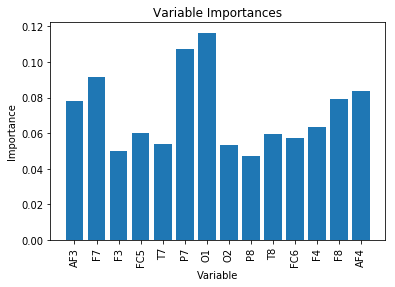

In [ ]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importancia: {}'.format(*pair)) for pair in feature_importances];

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');